In [67]:
from diabetic_env_discretized import Diabetic2Env
import gym
import numpy as np
import random
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from torch.optim import Adam
import itertools
import torch.nn as nn
import seaborn as sns


In [ ]:
diabetic_sim = Diabetic2Env()

In [ ]:
diabetic_sim.set_episode_length(10)

In [71]:
test_model = DQN.load("dqn_diabetes")

In [72]:
def random_model(env, num_episodes):
    """
    Used as a baseline, the model would randomly choose action for each state
    """
    nA = env.action_space.n
    
    #episode_lengths=np.zeros(num_episodes)
    random_episode_rewards=np.zeros(num_episodes)
    final_reward = []
    glucose_levels = []
    start_track = False
    
    for i_episode in range(num_episodes):
        if i_episode == num_episodes - 1:
            start_track = True
        
        last_reward = random_episode_rewards[i_episode - 1]
        # print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        # sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA)
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)
            new_action = np.random.choice(nA)
            
            if start_track:
                final_reward.append(reward)
                        
            random_episode_rewards[i_episode] += reward       
            
            # update current state
            state = new_state

            glucose_levels.append(state[0])
            
            if terminated:
                break
    
    return random_episode_rewards, final_reward, glucose_levels

In [73]:
dqn_glucose_levels = []
for episode in range(100):
    state = diabetic_sim.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = test_model.predict(state, deterministic=True)
        next_state, reward, done, info = diabetic_sim.step(action)
        total_reward += reward
        state = next_state
        dqn_glucose_levels.append(state[0])


In [74]:
_, _, patient_glucose_levels = random_model(diabetic_sim, num_episodes=100)

In [78]:
dqn_glucose_levels = np.array(dqn_glucose_levels)
patient_glucose_levels = np.array(patient_glucose_levels)

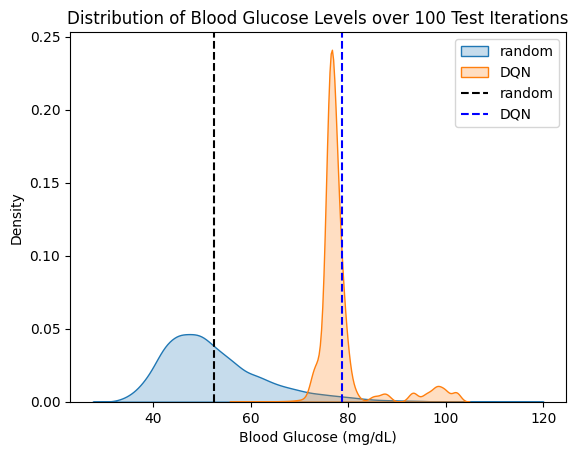

In [82]:
sns.kdeplot(patient_glucose_levels, fill=True, label='random')
sns.kdeplot(dqn_glucose_levels, fill=True, label='DQN')

# Adding vertical lines for mean or target glucose levels if needed
plt.axvline(x=patient_glucose_levels.mean(), color='k', linestyle='--', label='random')
plt.axvline(x=dqn_glucose_levels.mean(), color='b', linestyle='--', label='DQN')

# Adding labels and title
plt.xlabel('Blood Glucose (mg/dL)')
plt.ylabel('Density')
plt.title('Distribution of Blood Glucose Levels over 100 Test Iterations')
plt.legend()

# Display the plot
plt.show()